# Event & File ID for Events of Interest

__Actualmente:__ reviso los eventos con hits con Z negativos.

In [1]:
import sys
sys.path.append('/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/libs')

import crudo
import fit_functions as ff
import glob
from   iminuit import Minuit
from   iminuit.cost import LeastSquares
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotting_tools as pt
import re
from   scipy import integrate
from   scipy.optimize import curve_fit
from   scipy.stats    import linregress
import tables as tb

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Selection Criteria

In [2]:
def selection_criteria(group):

    return (
                # Multiplicity
                (group['nS1'].sum() == 1) &
                (group['nS2'].sum() == 1) &

                # 214Po-like events
                (group['S1h'].sum() < 0.17 * group['S1e'].sum() - 56)  # Reject (>=) or select (<)
           )

## File Processing

### Preliminary

In [2]:
# ----- Run Number ----- #
run_id = 15502

# Data directory
data_dir = f'/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/sophronia/run_{run_id}/'

# Key for the DST table within HDF5 files
dorothea  = 'DST/Events'
sophronia = 'RECO/Events'

# Output .txt file with important information
# output_file = f'run_{run_id}_Polike_event_file_ids.txt'
output_file = f'run_{run_id}_Zneg_event_file_ids.txt'

In [9]:
test_path = os.path.join(data_dir, f'run_{run_id}_1285_ldc1_trg2.v2.3.1.20250512.HEDesman.sophronia.h5')
test_soph = pd.read_hdf(test_path, key=sophronia)
test_doro = pd.read_hdf(test_path, key=dorothea)

In [11]:
test_soph

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1695933,1.749082e+09,0,103.673371,203.154105,1,165.475,430.525,0.0,0.0,96.901750,12.332203,200.323433,-1.0,0.001493,-1,-1.0
1,1695933,1.749082e+09,0,103.673371,203.154105,1,165.475,446.075,0.0,0.0,96.901750,7.785701,126.470381,-1.0,0.001096,-1,-1.0
2,1695933,1.749082e+09,0,103.673371,203.154105,1,165.475,461.625,0.0,0.0,96.901750,7.633325,123.995193,-1.0,NaN,-1,-1.0
3,1695933,1.749082e+09,0,103.673371,203.154105,1,181.025,414.975,0.0,0.0,96.901750,19.215542,312.135904,-1.0,0.002133,-1,-1.0
4,1695933,1.749082e+09,0,103.673371,203.154105,1,181.025,430.525,0.0,0.0,96.901750,32.882515,534.141249,-1.0,0.004309,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,1695933,1.749082e+09,0,103.673371,203.154105,1,-96.875,-386.625,0.0,0.0,115.662000,7.155776,2524.350660,-1.0,0.014298,-1,-1.0
1545,1695933,1.749082e+09,0,103.673371,203.154105,1,-482.625,245.425,0.0,0.0,135.649125,7.494786,1007.178968,-1.0,NaN,-1,-1.0
1546,1695933,1.749082e+09,0,103.673371,203.154105,1,-34.675,-340.975,0.0,0.0,139.605500,7.450778,559.225113,-1.0,0.002970,-1,-1.0
1547,1695933,1.749082e+09,0,103.673371,203.154105,1,-451.525,122.025,0.0,0.0,159.578375,8.015517,87.028356,-1.0,0.000696,-1,-1.0


In [13]:
test_doro

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,1695933,1.749082e+09,0,0,1,1,700.0,106.639198,667.263428,1304300.0,...,2999,101.181877,101.181877,3.588688,103.673371,203.154105,228.078403,1.098928,201.513946,264.79496


In [ ]:
# Event counters
reco_evts = 0
sel_evts  = 0

# ----- File Processing and Data Accumulation ----- #
# Pattern to match the HDF5 files for the given run_id
file_pattern = f"run_{run_id}_*_ldc1_trg2.v2.3.1.20250512.HEDesman.sophronia.h5"
h5_files = sorted(glob.glob(os.path.join(data_dir, file_pattern)))

if not h5_files:
    print(f"\nError: No HDF5 files found matching pattern '{file_pattern}' in '{data_dir}'.")
    print("Please check the run_id, data_dir, and file_pattern.")
else:
    print(f"\nFound {len(h5_files)} HDF5 files to process.")

    all_selected_events_data = []       # List to store DataFrames of selected events

    # Open the output text file in write mode (overwrites if exists)
    with open(output_file, 'w') as txt_file:

        # Write a header to the text file
        txt_file.write("FileID\tEventID\n")

        # ----- Files Loop ----- #
        for i, file_path in enumerate(h5_files):

            base_filename = os.path.basename(file_path)
            print(f"  Processing file {i+1}/{len(h5_files)}: {base_filename}")

            # Extract file_id from the filename
            # Example: run_15331_2524_ldc1... -> file_id = 2524
            # This regex assumes file_id is the number between the first two underscores after run_id
            match = re.search(f"run_{run_id}_(\d+)_.*", base_filename)
            file_id_str = match.group(1) if match else f"UNKNOWN_FILE_ID_{i}"

            try:
                # ----- Sophronia ----- #
                sophronia_df = pd.read_hdf(file_path, key=sophronia)
                if sophronia_df.empty:
                    print(f"    - Table '{sophronia}' is empty or not found. Skipping.")
                    continue
                if 'event' not in sophronia_df.columns:
                    print(f"    - Error: 'event' column not found in '{sophronia}'. Skipping file.")
                    continue
                reco_evts += sophronia_df['event'].nunique()

                # # ----- Dorothea ----- #
                # dorothea_df = pd.read_hdf(file_path, key=dorothea)
                # if dorothea_df.empty:
                #     print(f"    - Table '{dorothea}' is empty or not found. Skipping.")
                #     continue
                # if 'event' not in dorothea_df.columns:
                #     print(f"    - Error: 'event' column not found in '{dorothea}'. Skipping file.")
                #     continue

                # ----- Apply Selection Criteria ----- #
                # selected_events_this_file = dorothea_df.groupby('event').filter(selection_criteria)
                selected_events_this_file = sophronia_df.loc[sophronia_df['Z'] < 0, 'event'].unique()
                # print(selected_events_this_file)

                if selected_events_this_file.size > 0:
                    print(f"    - Found {len(selected_events_this_file)} events passing cuts.")
                    
                    # ----- Save Event and File IDs to Text File ----- #
                    for event_id_passed in selected_events_this_file:
                        txt_file.write(f"{file_id_str}\t{event_id_passed}\n")

                    sophronia_df = sophronia_df[sophronia_df['event'].isin(selected_events_this_file)].copy()
                    sel_evts += sophronia_df['event'].nunique()
                    
                    # ----- Accumulate DataFrame ----- #
                    all_selected_events_data.append(sophronia_df)
                else:
                    print(f"    - No events passed selection criteria in this file.")

            except FileNotFoundError:
                print(f"    - Error: File not found at path: {file_path} (should not happen if glob worked).")
            except KeyError as e:
                print(f"    - Error: Key '{e}' not found in HDF5 file {base_filename}.")
            except Exception as e:
                print(f"    - Error processing file {base_filename}: {e}")

    # ----- Final Dataframe ----- #
    if all_selected_events_data:
        print(f"\nConcatenating data from {len(all_selected_events_data)} file(s) into a global DataFrame...")
        global_selected_df = pd.concat(all_selected_events_data, ignore_index=True)
        print(f"→ Selected dataframe created with shape: {global_selected_df.shape}")
        
    else:
        print("\nNo events passed selection criteria from any file. Selected dataframe is empty.")
        global_selected_df = pd.DataFrame() # Create an empty DataFrame

print(f"\nTotal number of reconstructed events: {reco_evts}")
print(f"Total number of selected events: {sel_evts}")
print("\nY ya, eso es todo, eso es todo")



Found 2023 HDF5 files to process.
  Processing file 1/2023: run_15502_0000_ldc1_trg2.v2.3.1.20250512.HEDesman.sophronia.h5
    - No events passed selection criteria in this file.
  Processing file 2/2023: run_15502_0002_ldc1_trg2.v2.3.1.20250512.HEDesman.sophronia.h5
    - No events passed selection criteria in this file.
  Processing file 3/2023: run_15502_0003_ldc1_trg2.v2.3.1.20250512.HEDesman.sophronia.h5
    - Found 1 events passing cuts.
  Processing file 4/2023: run_15502_0004_ldc1_trg2.v2.3.1.20250512.HEDesman.sophronia.h5
    - No events passed selection criteria in this file.
  Processing file 5/2023: run_15502_0005_ldc1_trg2.v2.3.1.20250512.HEDesman.sophronia.h5
    - No events passed selection criteria in this file.
  Processing file 6/2023: run_15502_0007_ldc1_trg2.v2.3.1.20250512.HEDesman.sophronia.h5
    - No events passed selection criteria in this file.
  Processing file 7/2023: run_15502_0008_ldc1_trg2.v2.3.1.20250512.HEDesman.sophronia.h5
    - No events passed sele

In [24]:
global_selected_df[global_selected_df['Z'] < 0].event.nunique()

484

#### Are they what we are looking for?

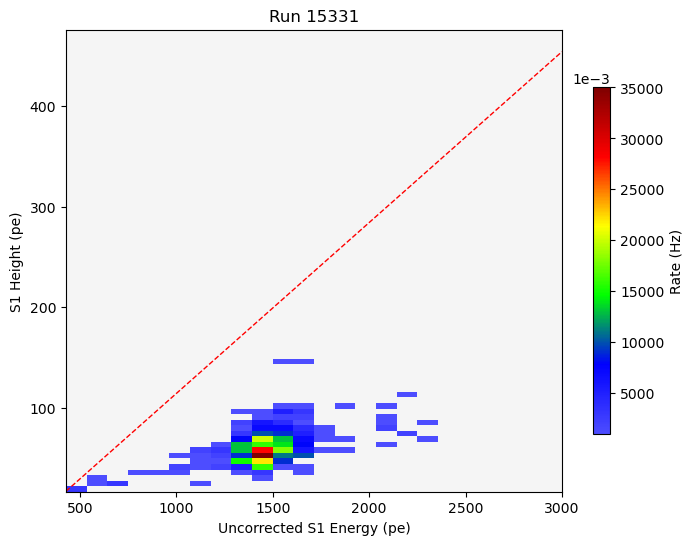

In [11]:
# Global
n_bins  = 25
E1_max  = 3e3

# Limit line parameters: from selecting_criteria.ipynb
m = 0.17
b = -56

# ----- Data ----- #
data = global_selected_dst_df

# Variables
H1 = data['S1h']
E1 = data['S1e']

# Binning
H1_bins = np.linspace(H1.min(), H1.max(), n_bins)
E1_bins = np.linspace(E1.min(), E1_max, n_bins)

# 2D histogram: normalized by corrected DAQ data taking time
S1h_S1e_map, ex, ey = np.histogram2d(E1, H1, bins=[E1_bins, H1_bins])
S1h_S1e_map         = np.ma.masked_where(S1h_S1e_map==0, S1h_S1e_map)     # Zero values masked
# S1h_S1e_map         = np.clip(S1h_S1e_map, 0, 0.8e-3)                     # Clipped values in colorbar

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
plt.pcolormesh(ex, ey, S1h_S1e_map.T, cmap=pt.custom_hsv, shading='auto')
plt.plot(E1_bins, ff.linear_func(E1_bins, 0.17, -56), c='red', ls='--', lw=1)       # Limit line

# ----- Styling ----- #
cbar = plt.colorbar(label='Rate (Hz)', shrink=0.75)
cbar.formatter.set_powerlimits((-3, -3))
plt.xlabel('Uncorrected S1 Energy (pe)')
plt.ylabel('S1 Height (pe)')
plt.title(f'Run {run_id}')

plt.gca().set_facecolor("whitesmoke")
plt.show() 